In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import pytz

class AnomalyScorer:
    def __init__(self, df, coin_name="UNKNOWN"):
        self.df = df.copy()
        self.coin_name = coin_name
        self._prepare_data()

    def _prepare_data(self):
       # 기본 지표 계산
        self.df['price_change'] = self.df['close'].pct_change()
        self.df['price_change_abs'] = self.df['price_change'].abs()
        self.df['volume_change'] = self.df['volume'].pct_change()
        self.df['volume_change_abs'] = self.df['volume_change'].abs()
        self.df['hl_spread'] = (self.df['high'] - self.df['low']) / self.df['close']

        self.df.dropna(inplace=True)

    def compute_realtime_score(self, lookback_window=30, threshold=0.7): #30(윈도우:파라미터), 0.7(이상치 검출:파라미터)
        """
        실시간 이상치 탐지: rolling 기반 평균 및 표준편차로 계산
        """
        scores = []
        flags = []

        for i in range(lookback_window, len(self.df)):
            hist = self.df.iloc[i - lookback_window:i]

            price_mean = hist['price_change_abs'].mean()
            price_std = hist['price_change_abs'].std()
            volume_mean = hist['volume'].mean()
            volume_std = hist['volume'].std()

            current = self.df.iloc[i]
            price_score = abs(current['price_change_abs'] - price_mean) / (price_std + 1e-8)
            volume_score = abs(current['volume'] - volume_mean) / (volume_std + 1e-8) #표준화

            composite_score = min(1.0, (price_score * 0.6 + volume_score * 0.4) / 5) # 1 클리핑(가중치 :파라미터)
            is_anomaly = composite_score > threshold

            scores.append(composite_score)
            flags.append(is_anomaly)

        self.df.loc[self.df.index[lookback_window:], 'realtime_score'] = scores
        self.df.loc[self.df.index[lookback_window:], 'realtime_flag'] = pd.Series(flags, dtype=bool).values

        return self.df[['timestamp', 'realtime_score', 'realtime_flag']].dropna()

In [8]:
# 실시간 이상치 탐지

from datetime import datetime
import pytz

# CSV 불러오기
df = pd.read_csv('./Anomaly_Detection/candle_data/BERA.csv')  # 또는 다른 코인

# timestamp가 밀리초 단위인지 확인 후 변환 (13자리면 밀리초)
if df['timestamp'].astype(str).str.len().max() > 10:
    df['timestamp'] = df['timestamp'] / 1000  # 밀리초 → 초

# UTC 기준 datetime으로 변환
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)

# 한국 시간 (KST, UTC+9)으로 변환
df['timestamp'] = df['timestamp'].dt.tz_convert('Asia/Seoul')

df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

# 이상치 분석기 생성
detector = AnomalyScorer(df, coin_name="BERA")

# 실시간 이상치 탐지
realtime = detector.compute_realtime_score()

# 결과 확인
print(realtime)

                     timestamp  realtime_score realtime_flag
31   2025-08-08 00:53:00+09:00        0.066845         False
32   2025-08-08 00:56:00+09:00        0.104228         False
33   2025-08-08 01:00:00+09:00        0.681934         False
34   2025-08-08 01:01:00+09:00        0.112553         False
35   2025-08-08 01:03:00+09:00        0.156432         False
...                        ...             ...           ...
7617 2025-08-15 12:46:00+09:00        0.106521         False
7618 2025-08-15 12:47:00+09:00        0.076432         False
7619 2025-08-15 12:48:00+09:00        0.061893         False
7620 2025-08-15 12:49:00+09:00        0.026651         False
7621 2025-08-15 12:50:00+09:00        0.125999         False

[7591 rows x 3 columns]


In [9]:
# 이상치 개수 파악

result = detector.compute_realtime_score()

# 이상치 개수
anomaly_count = result['realtime_flag'].sum()

# 전체 개수
total_count = len(result)

# 비율 계산
anomaly_ratio = anomaly_count / total_count * 100

print(f"이상치 개수: {anomaly_count}개")
print(f"전체 중 이상치 비율: {anomaly_ratio:.2f}%")

이상치 개수: 164개
전체 중 이상치 비율: 2.16%


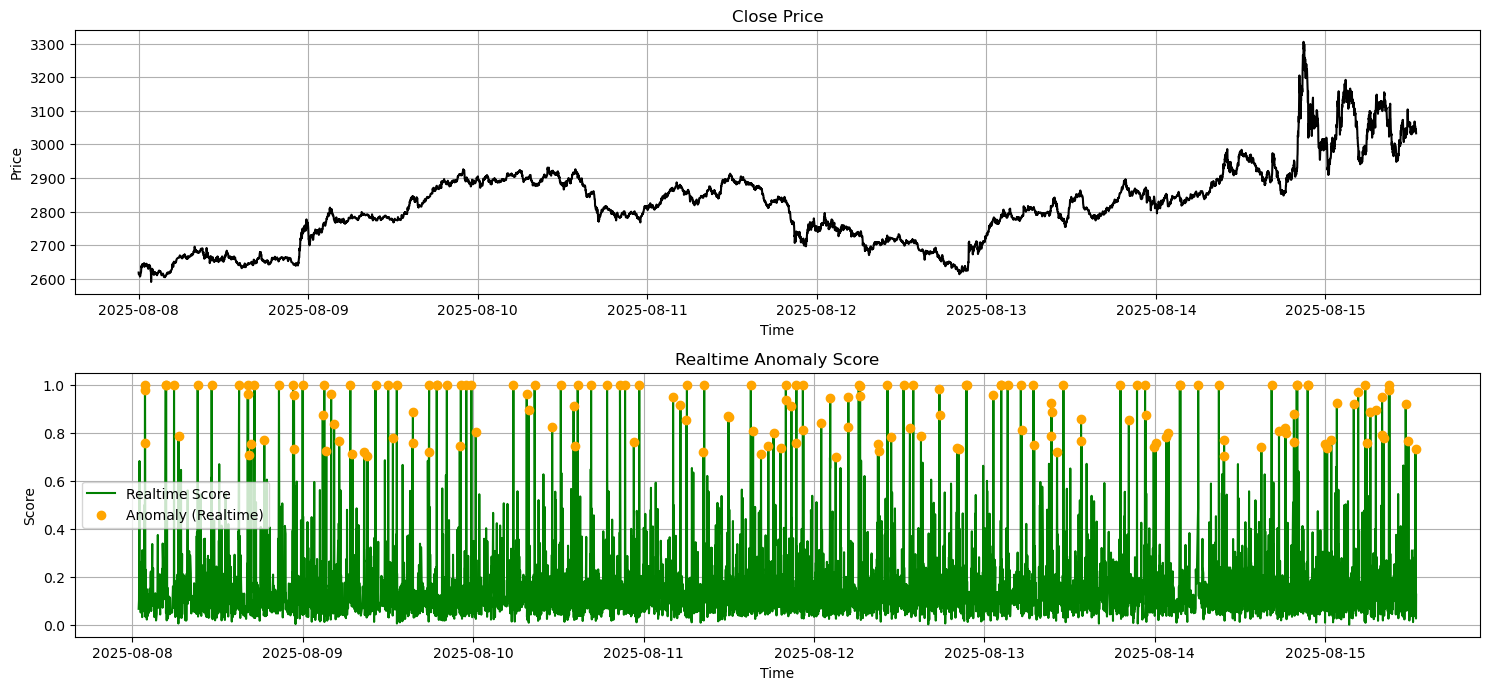

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# 1. 가격 시계열
plt.subplot(3, 1, 1)
plt.plot(df['timestamp'], df['close'], label='Close Price', color='black')
plt.title('Close Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)


# 2. 실시간 이상치 점수
plt.subplot(3, 1, 2)
plt.plot(realtime['timestamp'], realtime['realtime_score'], label='Realtime Score', color='green')
plt.scatter(
    realtime[realtime['realtime_flag']]['timestamp'],
    realtime[realtime['realtime_flag']]['realtime_score'],
    color='orange', label='Anomaly (Realtime)', zorder=5
)
plt.title('Realtime Anomaly Score')
plt.xlabel('Time')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()